### Definitions, Contsants, and Paths

In [1]:
# Constants
PARAM_NUM_EPOCHS = 30
PARAM_BATCH_SIZE = 300
NUM_SAMPLES = 200

# Paths
dataset_folder_path = 'temp'
tensorboard_logs_path = "logs"
checkpoints_save_folder_path = 'checkpoints'
checkpoints_save_prefix = 'gru-spline'

### Data Preparation

In [2]:
# Imports
from utils.preprocessing import *
from data.DataSet import DataSet
from functools import partial

dataset = DataSet(dataset_folder_path)
dataset.apply(apply_mean_centering)
dataset.apply(apply_unit_distance_normalization)
#dataset.apply(partial(normalize_pressure_value, max_pressure_val=512))
dataset.apply(partial(spline_interpolate_and_resample, num_samples=NUM_SAMPLES))
dataset.expand(reverse_digit_sequence)
# dataset.apply(lambda digit: convert_xy_to_derivative(digit, normalize=False))
#dataset.apply(partial(convert_xy_to_derivative, normalize=True))

### Split Dataset into *Train*, *Valid*, and *Test*

In [3]:
# Imports
import numpy as np
from sklearn.model_selection import train_test_split

data = np.array(dataset.data)
# Convert labels to numpy array and OneHot encode them
encoder, labels = dataset.get_labels_as_numpy(onehot=True)
labels = labels.astype('float32').todense()
# Split Data
X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(data, labels, shuffle=True, stratify=labels, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_valid, Y_train_valid, shuffle=True, stratify=Y_train_valid, random_state=42)

### Setup Model

In [4]:
from models.naive_gru import NaiveGRU

mymodel = NaiveGRU(X_train.shape[1:])
mymodel.batch_size = PARAM_BATCH_SIZE
mymodel.num_epochs = PARAM_NUM_EPOCHS
mymodel.initialize()
print(mymodel)

Using TensorFlow backend.




----------

Optimizer: <class 'keras.optimizers.Adam'>
Batch Size: 300
Number of Epochs: 30

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 200, 256)          198912    
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 595,466
Trainable params: 595,466
Non-trainable params: 0
_________________________________________________________________


----------




#### Save Model Summary

In [5]:
mymodel.save_summary(dataset.get_recorded_operations())
mymodel.save_config()

### Train Model

In [6]:
mymodel.train(X_train, Y_train, X_valid, Y_valid)

Train on 3037 samples, validate on 1013 samples
Epoch 1/30
3037/3037 [==============================] - 4s 1ms/step - loss: 2.2028 - categorical_accuracy: 0.1801 - val_loss: 2.1441 - val_categorical_accuracy: 0.2280

Epoch 00001: val_categorical_accuracy improved from -inf to 0.22804, saving model to checkpoints/1523369406.7123575/naive_overfit_gru-01-0.23.hdf5
Epoch 2/30
3037/3037 [==============================] - 3s 1ms/step - loss: 2.1271 - categorical_accuracy: 0.2371 - val_loss: 2.1104 - val_categorical_accuracy: 0.2221

Epoch 00002: val_categorical_accuracy did not improve
Epoch 3/30
3037/3037 [==============================] - 3s 1ms/step - loss: 2.0970 - categorical_accuracy: 0.2170 - val_loss: 2.0451 - val_categorical_accuracy: 0.2340

Epoch 00003: val_categorical_accuracy improved from 0.22804 to 0.23396, saving model to checkpoints/1523369406.7123575/naive_overfit_gru-03-0.23.hdf5
Epoch 4/30
3037/3037 [==============================] - 3s 1ms/step - loss: 1.9906 - categoric

### Evaluate Model

#### Test Set Accuracy

In [7]:
test_score = tuple(mymodel.model.evaluate(X_test, Y_test))
print("Test Loss: %.3f, Test Acc: %.3f%%" % (test_score[0], test_score[1] * 100))

1350/1350 [==============================] - 2s 2ms/step
Test Loss: 0.151, Test Acc: 96.963%


#### Recall, Precision, F1_Score on Validation set

In [8]:
from utils.evaluation import get_evaluation_metrics, get_confusion_matrix

Y_predicted_valid = mymodel.model.predict_classes(X_valid, verbose=1)
rpf = get_evaluation_metrics(Y_valid, Y_predicted_valid)
rpf

1013/1013 [==============================] - 2s 2ms/step


,recall,precision,f1 score,#
0,0.952830,1.000000,0.975845,101.0
1,0.969697,0.950495,0.960000,101.0
2,0.960396,0.960396,0.960396,101.0
3,1.000000,1.000000,1.000000,102.0
4,0.979592,0.950495,0.964824,101.0
5,0.970000,0.950980,0.960396,102.0
6,0.980392,0.980392,0.980392,102.0
7,0.961165,0.980198,0.970588,101.0
8,0.951923,0.980198,0.965854,101.0
9,0.979592,0.950495,0.964824,101.0


#### Plot Confusion Matrix

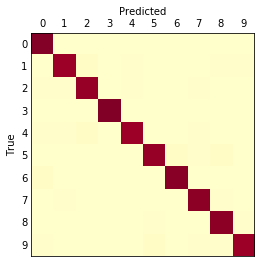

In [9]:
from utils.evaluation import get_confusion_matrix
# Confusion Matrix
confmat = get_confusion_matrix(Y_valid, Y_predicted_valid, plot=True)

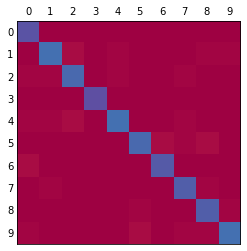

In [18]:
import matplotlib.cm
from utils.plot import show_mat
show_mat(confmat, hide_ticks=True, uniform_ticks=True, cmap=matplotlib.cm.Spectral)

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 432x288 with 0 Axes>